In [123]:
library(limma)
library(DESeq2)
library(edgeR)

## **Data Loading**

In [124]:
# loading pseudo-bulk file from python : 17 sec
pb <- read.csv("pseudobulk_matrix.csv")

In [125]:
head(pb)

,class,donor_id,disease,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,⋯,ENSG00000288600,ENSG00000288602,ENSG00000288605,ENSG00000288606,ENSG00000288611,ENSG00000288612,ENSG00000288622,ENSG00000288637,ENSG00000288642,ENSG00000288643
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Astro,Donor_31,dementia || Alzheimer disease,71,7,242,173,139,1,4,⋯,0,98,37,6,0,21,4,3,15,13
2,Astro,Donor_228,dementia || Alzheimer disease,63,1,258,197,123,2,1,⋯,1,119,25,10,1,30,3,5,10,17
3,Astro,Donor_333,dementia || Alzheimer disease,110,12,140,102,101,1,5,⋯,0,69,13,7,1,18,1,3,39,16
4,Astro,Donor_545,dementia || Parkinson disease,19,3,154,112,69,1,1,⋯,0,91,21,7,1,19,2,6,13,18
5,Astro,Donor_609,normal,60,6,245,156,106,2,8,⋯,0,121,13,12,1,27,0,3,31,21
6,Astro,Donor_614,dementia || Alzheimer disease,30,4,107,73,56,2,0,⋯,1,70,5,8,0,10,0,0,8,5


## **Defining counts and phenotype (meta)**

In [126]:

# Séparer l’expression et les métadonnées
counts <- pb[, !(colnames(pb) %in% c("class", "donor_id", "disease"))]
counts <- t(as.matrix(counts))
# rownames(expr) <- paste(pb$class, pb$donor_id, pb$disease, sep="_")

meta <- data.frame(
  class = pb$class,
  donor = pb$donor_id,
  disease = factor(meta$disease,levels = c("dementia || Alzheimer disease", "dementia || Parkinson disease", "normal"))
)


In [127]:
# checking for the dimensions
cat("genes:", nrow(counts), "\n")
cat("samples:", ncol(counts), "\n")
cat("meta rows:", nrow(meta), "\n")

genes: 34167 
samples: 136 
meta rows: 136 


## **edgeR**

code for the edgeR

In [128]:
for (ct in unique(meta$class)) {
  idx <- meta$class == ct
  cts  <- counts[, idx, drop = FALSE]
  pheno <- meta[idx, , drop = FALSE]


  ### PART 1 : edgeR
  y <- DGEList(counts = cts, samples = pheno) 

  # 1. filtrer the low-expressed genes 
  #(deletes the genes with a lot of zeros, reduces the noise, enhance statistical power)
  
  keep <- filterByExpr(y, design = design)
  y <- y[keep, , keep.lib.sizes = FALSE]


  # 2. Normalization (TMM = Trimmed Mean of M-values)
  y <- calcNormFactors(y, method = "TMM")

  # 3. Creation of the design matrix
  design <- model.matrix(~ 0 + disease, data = pheno)
  colnames(design) <- c("AD", "PD", "CTRL") # in the same order than in meta

  # 4. Estimations of the 3 dispersions 
  # shared dispersion (global), trended dispersion (dep of expression levels), tagwise dispersion (per gene)
  y <- estimateDisp(y, design)

  #5. Fit of the GLM model (QLF)
  fit <- glmQLFit(y, design)

  ### PART 2 : multiple comparisons
  cont <- makeContrasts(
    AD_vs_CTRL = AD - CTRL,
    PD_vs_CTRL = PD - CTRL,
    AD_vs_PD   = AD - PD,
    levels = design
  )

  ### PART 3 : make and save the comparisons
  for (cn in colnames(cont)) {
    qlf <- glmQLFTest(fit, contrast = cont[, cn])
    tab <- topTags(qlf, n = Inf)$table  # contiens FDR !

    out <- paste0("edgeR_results/edgeR_", ct, "_", cn, ".csv")
    write.csv(tab, out, row.names = TRUE)
  }
}

visualization of 1 file

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000026508,-2.208076,1.8310094,80.15824,3.322031e-09,7.366603e-05
ENSG00000259520,-2.392017,2.8966387,43.42480,9.497231e-07,1.053005e-02
ENSG00000188393,4.805315,0.3616510,33.29128,2.107895e-06,1.558086e-02
ENSG00000225231,4.477924,1.9544468,31.93970,8.264007e-06,4.581359e-02
ENSG00000205628,3.342051,0.6676387,27.07937,1.839400e-05,8.157737e-02
ENSG00000236130,-1.650295,2.1818847,27.66827,2.465348e-05,9.111515e-02


[1] 94

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
7.367e-05 9.985e-01 9.985e-01 9.964e-01 9.985e-01 1.000e+00 

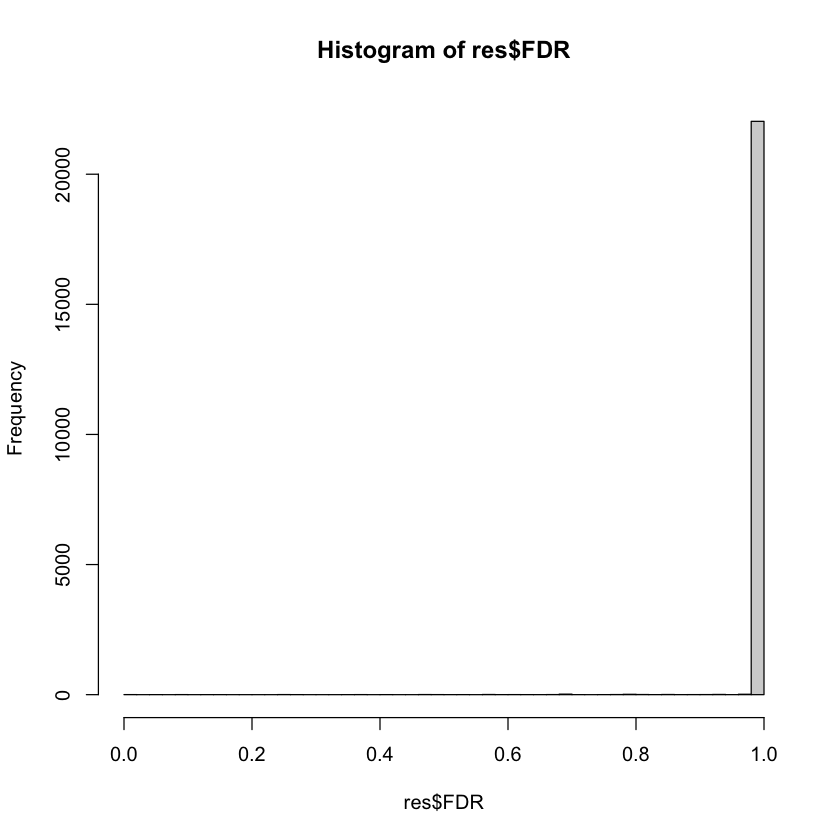

In [140]:
res <- read.csv("edgeR_results/edgeR_IN_AD_vs_CTRL.csv", row.names = 1)
head(res)
length(unique(res$FDR))  # si ça vaut 1 → très suspect
summary(res$FDR)
hist(res$FDR, breaks = 50)

format : 

y$counts     = matrix (genes × samples)

y$samples    = data.frame (samples × covariates)

## **DESes2** 

maybe need to re-run the defining counts and meta

In [131]:
for (ct in unique(meta$class)) {
  
  cat("\n=== Cell type :", ct, "===\n")
  
  idx <- meta$class == ct
  cts <- counts[idx, ]
  cts <- t(cts)  # DESeq2 = gènes × samples
  
  pheno <- meta[idx, ]
  
  # Vérifier au moins 2 conditions
  if (length(unique(pheno$disease)) < 2) {
    cat("Skip :", ct, "(not enough conditions)\n")
    next
  }
  
  # Création DESeq2
  dds <- DESeqDataSetFromMatrix(
    countData = cts,
    colData = pheno,
    design = ~ disease
  )
  
  dds <- DESeq(dds)
  
  ### --- 1) AD vs CTRL ---
  if (all(c("normal", "dementia || Alzheimer disease") %in% pheno$disease)) {
    
    res_ADvsCTRL <- results(
      dds,
      contrast = c("disease",
                   "dementia || Alzheimer disease",
                   "normal")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_ADvsCTRL.csv")
    write.csv(as.data.frame(res_ADvsCTRL), fname)
    cat("Saved:", fname, "\n")
  }
  
  ### --- 2) PD vs CTRL ---
  if (all(c("normal", "dementia || Parkinson disease") %in% pheno$disease)) {
    
    res_PDvsCTRL <- results(
      dds,
      contrast = c("disease",
                   "dementia || Parkinson disease",
                   "normal")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_PDvsCTRL.csv")
    write.csv(as.data.frame(res_PDvsCTRL), fname)
    cat("Saved:", fname, "\n")
  }
  
  ### --- 3) AD vs PD ---
  if (all(c("dementia || Alzheimer disease", 
            "dementia || Parkinson disease") %in% pheno$disease)) {
    
    res_ADvsPD <- results(
      dds,
      contrast = c("disease",
                   "dementia || Alzheimer disease",
                   "dementia || Parkinson disease")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_ADvsPD.csv")
    write.csv(as.data.frame(res_ADvsPD), fname)
    cat("Saved:", fname, "\n")
  }
}


=== Cell type : Astro ===


ERROR: Error in DESeqDataSetFromMatrix(countData = cts, colData = pheno, design = ~disease): ncol(countData) == nrow(colData) is not TRUE


vizualisation of one file

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,7.618874,-0.235953345,0.5166267,-0.456719212,0.6478729,1
ENSG00000000005,1.277961,1.064173276,1.4979016,0.710442705,0.4774296,1
ENSG00000000419,210.721631,0.001008416,0.1612832,0.006252452,0.9950113,1
ENSG00000000457,113.876740,-0.272815484,0.1785876,-1.527628723,0.1266047,1
ENSG00000000460,96.303641,0.127990125,0.2969305,0.431044015,0.6664364,1
ENSG00000000938,1.624470,-0.200112617,1.1556028,-0.173167299,0.8625199,1


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.000011 1.000000 1.000000 0.999821 1.000000 1.000000      161 

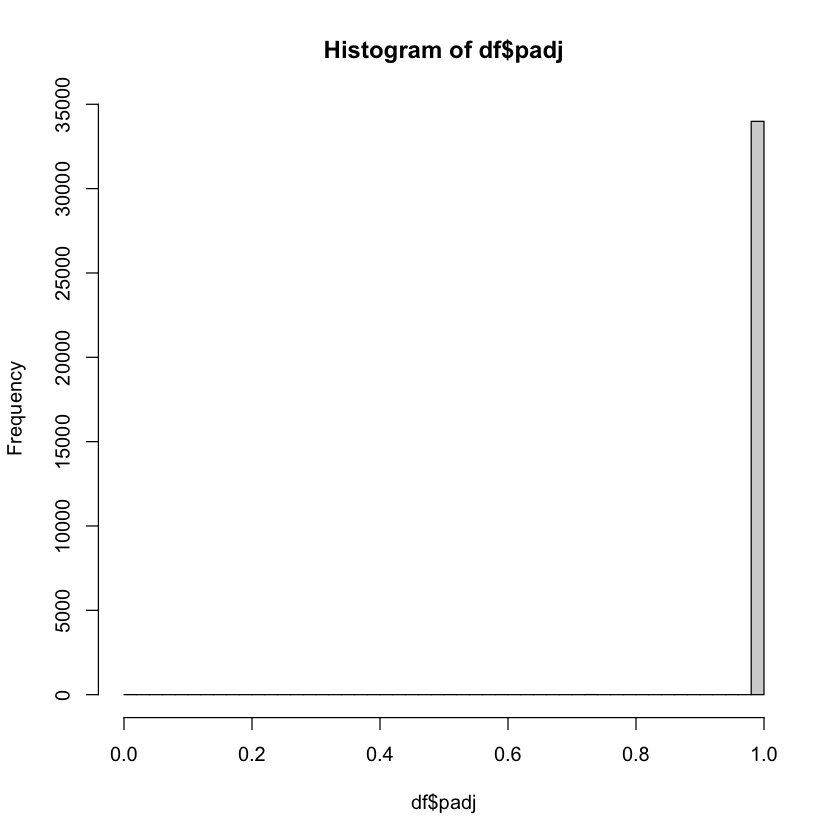

In [138]:
df <- read.csv("DESeq2_results/DE_IN_ADvsPD.csv", row.names = 1)
head(df)
summary(df$padj)
hist(df$padj, breaks = 50)